# **Predicting Laptop Prices**
### IEOR 142A Final Project

*By: Khoa Nguyen, Yusuf Ahmad, Melad Mayaar, Safwan Masood, Yuki Kuwahara, TM Carillo*

In this project, we aim to use various forms of regression to predict the price of a laptop. We hope this helps to help new entrants into the laptop market set competitive and profitable prices.

## **Data Cleaning**

We will load the dataset laptop_prices.csv and conduct basic data cleaning.

In [ ]:
# Importing necessary functions

import pandas as pd
import numpy as np
import warnings
import re
warnings.filterwarnings('ignore')

In [ ]:
# Loading the dataset

df = pd.read_csv('laptop_price.csv', encoding='latin-1')
df.head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [ ]:
# Dropping any null values

df.dropna(how='any', inplace=True)
print(df.isnull().sum())

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64


In [ ]:
# Converting Price_euros to Price_usd

df["Price_usd"] = np.around(df["Price_euros"] / 1.07, 2)
df.drop(['Price_euros'], axis=1, inplace=True)
df.head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_usd
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1252.05
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,840.13
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,537.38
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2371.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1685.61


## **Feature Engineering**

Create helper functions to create new features from the dataset in order to help with modeling.

In [ ]:
# Extracting the CPU Name from Cpu column

def cpu_name_model(df):
    new_df = df.copy()
    new_df["CPUName"] = new_df["Cpu"].str.extract(r'(i\d+ \d+U)', flags=re.IGNORECASE)
    new_df["CPUName"] = new_df["CPUName"]  # Remove the last 7 characters
    return new_df

In [ ]:
# Adding a resolution column

def add_resolution(df):
    new_df = df.copy()
    new_df["Resolution"] = pd.Series(dtype="str")
    for i in range(len(df)):
        if len(df.iloc[i]["ScreenResolution"].split(" ")) > 1:
            new_df["Resolution"].iloc[i] = df.iloc[i]["ScreenResolution"].split(" ")[-1]
        if len(df.iloc[i]["ScreenResolution"].split(" ")) == 1:
             new_df["Resolution"].iloc[i] = df.iloc[i]["ScreenResolution"].split(" ")[0]
    return new_df

In [ ]:
# Adding resolution height and width columns

def add_width_height_res(df):
    df["ResolutionWidth"] = df["Resolution"].str.extract(r'(\d+)x(\d+)')[0]
    df["ResolutionHeight"] = df["Resolution"].str.extract(r'(\d+)x(\d+)')[1]
    df = df.drop(["Resolution"], axis=1)
    return df

In [ ]:
# Adding CPU Brand and Speed Columns

def add_cpu_and_speed(df):
    new_df = df.copy()
    new_df["CPUBrand"] = pd.Series(dtype="str")
    new_df["Speed(GHz)"] = pd.Series(dtype="float")
    for i in range(len(df)):
        new_df["CPUBrand"].iloc[i] = df.iloc[i]["Cpu"].split(" ")[0]
    regex_pattern = r'(\d+\.\d+)GHz'
    new_df["Speed(GHz)"] = df["Cpu"].str.extract(regex_pattern)
    return new_df

In [ ]:
# Adding GPU Brand column

def add_gpu(df):
    new_df = df.copy()
    new_df["GPUBrand"] = pd.Series(dtype="str")
    for i in range(len(df)):
        new_df["GPUBrand"].iloc[i] = df.iloc[i]["Gpu"].split(" ")[0]
    return new_df

In [ ]:
# Adding a Storage column and converted TB to GB

def add_storage(df):
    new_df = df.copy()
    new_df["Storage(GB)"] = pd.Series(dtype='int')
    for i in range(len(df)):
        if df.iloc[i]["Memory"].split(" ")[0][-2:] == "GB":
            new_df["Storage(GB)"].iloc[i] = df.iloc[i]["Memory"].split(" ")[0][:-2]
        if df.iloc[i]["Memory"].split(" ")[0][-2:] == "TB":
            new_df["Storage(GB)"].iloc[i] = int(float(df.iloc[i]["Memory"].split(" ")[0][:-2]) * 1000)
    return new_df

In [ ]:
# Adding RAM storage in GB

def ram(df):
    new_df = df.copy()
    new_df["Ram(GB)"] = pd.Series(dtype="float")
    for i in range(len(df)):
        new_df["Ram(GB)"].iloc[i] = df.iloc[i]["Ram"][:-2]
    return new_df

In [ ]:
# Converting the existing kgs to lbs for weight

def kgs_to_lbs(df):
    new_df = df.copy()
    new_df["Weight(lbs)"] = pd.Series(dtype="float")
    for i in range(len(df)):
        new_df["Weight(lbs)"].iloc[i] = np.around(float(df.iloc[i]["Weight"][:-2]) * 2.20462, 2)
    return new_df

In [ ]:
# Running all helper functions

df = add_resolution(df)
df = add_cpu_and_speed(df)
df = add_storage(df)
df = add_gpu(df)
df = ram(df)
df = kgs_to_lbs(df)
df = cpu_name_model(df)
df = add_width_height_res(df)
df.head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,...,Price_usd,CPUBrand,Speed(GHz),Storage(GB),GPUBrand,Ram(GB),Weight(lbs),CPUName,ResolutionWidth,ResolutionHeight
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,...,1252.05,Intel,2.3,128,Intel,8,3.02,NaN,2560,1600
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,...,840.13,Intel,1.8,128,Intel,8,2.95,NaN,1440,900
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,...,537.38,Intel,2.5,256,Intel,8,4.10,i5 7200U,1920,1080
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,...,2371.45,Intel,2.7,512,AMD,16,4.03,NaN,2880,1800
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,...,1685.61,Intel,3.1,256,Intel,8,3.02,NaN,2560,1600


In [ ]:
# Dropping uncessary columns

df = df.drop(['Company', "laptop_ID", "Product", "ScreenResolution", "Ram", "Memory", "Cpu", "Gpu", "Weight"], axis=1)
df.dropna(how="any", inplace=True)

In [ ]:
df.head(5)

,TypeName,Inches,OpSys,Price_usd,CPUBrand,Speed(GHz),Storage(GB),GPUBrand,Ram(GB),Weight(lbs),CPUName,ResolutionWidth,ResolutionHeight
2,Notebook,15.6,No OS,537.38,Intel,2.5,256,Intel,8,4.10,i5 7200U,1920,1080
8,Ultrabook,14.0,Windows 10,1397.20,Intel,1.8,512,Nvidia,16,2.87,i7 8550U,1920,1080
9,Ultrabook,14.0,Windows 10,719.63,Intel,1.6,256,Intel,8,3.53,i5 8250U,1920,1080
10,Notebook,15.6,No OS,368.13,Intel,2.5,500,Intel,4,4.10,i5 7200U,1366,768
16,Notebook,15.6,Windows 10,696.26,Intel,2.7,256,AMD,8,4.85,i7 7500U,1920,1080


In [ ]:
# Altering datatypes

df['Speed(GHz)'] = df['Speed(GHz)'].astype(float)
df['Storage(GB)'] = df['Storage(GB)'].astype(int)
df['Ram(GB)'] = df['Ram(GB)'].astype(int)
df['ResolutionWidth'] = df['ResolutionWidth'].astype(int)
df['ResolutionHeight'] = df['ResolutionHeight'].astype(int)

## **CPU Data Augmentation**

In [ ]:
# Loading CPU dataset

cpu = pd.read_csv('Intel_CPUs.csv')
cpu.head(5)

,Product_Collection,Vertical_Segment,Processor_Number,Status,Launch_Date,Lithography,Recommended_Customer_Price,nb_of_Cores,nb_of_Threads,Processor_Base_Frequency,...,T,Intel_Hyper_Threading_Technology_,Intel_Virtualization_Technology_VTx_,Intel_64_,Instruction_Set,Instruction_Set_Extensions,Idle_States,Thermal_Monitoring_Technologies,Secure_Key,Execute_Disable_Bit
0,7th Generation Intel® Core™ i7 Processors,Mobile,i7-7Y75,Launched,Q3'16,14 nm,$393.00,2,4.0,1.30 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
1,8th Generation Intel® Core™ i5 Processors,Mobile,i5-8250U,Launched,Q3'17,14 nm,$297.00,4,8.0,1.60 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
2,8th Generation Intel® Core™ i7 Processors,Mobile,i7-8550U,Launched,Q3'17,14 nm,$409.00,4,8.0,1.80 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes
3,Intel® Core™ X-series Processors,Desktop,i7-3820,End of Life,Q1'12,32 nm,$305.00,4,8.0,3.60 GHz,...,66.8°C,Yes,Yes,Yes,64-bit,"SSE4.2, AVX, AES",Yes,Yes,NaN,Yes
4,7th Generation Intel® Core™ i5 Processors,Mobile,i5-7Y57,Launched,Q1'17,14 nm,$281.00,2,4.0,1.20 GHz,...,100°C,Yes,Yes,Yes,64-bit,"SSE4.1/4.2, AVX 2.0",Yes,Yes,Yes,Yes


In [ ]:
# Selecting the processor number and core count features

cpu_trimmed = cpu[["Processor_Number", "nb_of_Cores"]]
cpu_trimmed.head(5)

,Processor_Number,nb_of_Cores
0,i7-7Y75,2
1,i5-8250U,4
2,i7-8550U,4
3,i7-3820,4
4,i5-7Y57,2


In [ ]:
# Using regex to extract important information

cpu_trimmed["Processor_Number"] = cpu_trimmed["Processor_Number"].str.replace('-', ' ')
cpu_trimmed["Processor_Number"] = cpu_trimmed["Processor_Number"].str.extract(r'(i\d+ \d+U)', flags=re.IGNORECASE)
cpu_trimmed.dropna(how="any", inplace=True)
cpu_trimmed.head(5)

,Processor_Number,nb_of_Cores
1,i5 8250U,4
2,i7 8550U,4
423,i5 7200U,2
424,i5 7260U,2
425,i5 7267U,2


In [ ]:
# Adding the core count feature to our laptop dataset

def add_cores(df, cpu_df):
    df["Cores"] = pd.Series(dtype="int")
    for i in range(len(df)):
        for j in range(len(cpu_df)):
            if df.iloc[i]["CPUName"] == cpu_df.iloc[j]["Processor_Number"]:
                df["Cores"].iloc[i] =  cpu_df.iloc[j]["nb_of_Cores"]

    df = df.dropna(how="any")
    df["Cores"] = df["Cores"].astype(int)
    df = df.drop(["CPUName"], axis=1)
    return df

df = add_cores(df, cpu_trimmed)
df.head(5)

,TypeName,Inches,OpSys,Price_usd,CPUBrand,Speed(GHz),Storage(GB),GPUBrand,Ram(GB),Weight(lbs),ResolutionWidth,ResolutionHeight,Cores
2,Notebook,15.6,No OS,537.38,Intel,2.5,256,Intel,8,4.10,1920,1080,2
8,Ultrabook,14.0,Windows 10,1397.20,Intel,1.8,512,Nvidia,16,2.87,1920,1080,4
9,Ultrabook,14.0,Windows 10,719.63,Intel,1.6,256,Intel,8,3.53,1920,1080,4
10,Notebook,15.6,No OS,368.13,Intel,2.5,500,Intel,4,4.10,1366,768,2
16,Notebook,15.6,Windows 10,696.26,Intel,2.7,256,AMD,8,4.85,1920,1080,2


## **Exploratory Data Analysis (EDA)**

In [ ]:
# Importing visualization packages

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Visualizing our cleaned dataset
df.head(5)

,TypeName,Inches,OpSys,Price_usd,CPUBrand,Speed(GHz),Storage(GB),GPUBrand,Ram(GB),Weight(lbs),ResolutionWidth,ResolutionHeight,Cores
2,Notebook,15.6,No OS,537.38,Intel,2.5,256,Intel,8,4.10,1920,1080,2
8,Ultrabook,14.0,Windows 10,1397.20,Intel,1.8,512,Nvidia,16,2.87,1920,1080,4
9,Ultrabook,14.0,Windows 10,719.63,Intel,1.6,256,Intel,8,3.53,1920,1080,4
10,Notebook,15.6,No OS,368.13,Intel,2.5,500,Intel,4,4.10,1366,768,2
16,Notebook,15.6,Windows 10,696.26,Intel,2.7,256,AMD,8,4.85,1920,1080,2


In [ ]:
# CPU Brands

df['CPUBrand'].value_counts()

CPUBrand
Intel    729
Name: count, dtype: int64

In [ ]:
# Drop CPU Brands since the only value is Intel

df.drop('CPUBrand', axis=1, inplace=True)
print(df.shape)

(729, 12)


In [ ]:
# Summary of the dataset

df.describe()

,Inches,Price_usd,Speed(GHz),Storage(GB),Ram(GB),Weight(lbs),ResolutionWidth,ResolutionHeight,Cores
count,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000
mean,14.771879,1029.405734,2.347325,461.349794,7.914952,4.074294,1899.042524,1070.364883,2.403292
std,1.229175,469.958044,0.358333,342.236439,3.492285,1.015545,445.042509,253.095047,0.803010
min,12.500000,316.820000,1.600000,128.000000,4.000000,1.790000,1366.000000,768.000000,2.000000
25%,14.000000,671.960000,2.300000,256.000000,6.000000,3.130000,1920.000000,1080.000000,2.000000
50%,15.600000,914.950000,2.500000,256.000000,8.000000,4.190000,1920.000000,1080.000000,2.000000
75%,15.600000,1307.470000,2.600000,512.000000,8.000000,4.850000,1920.000000,1080.000000,2.000000
max,17.300000,3083.180000,2.800000,2000.000000,32.000000,7.280000,3840.000000,2160.000000,4.000000


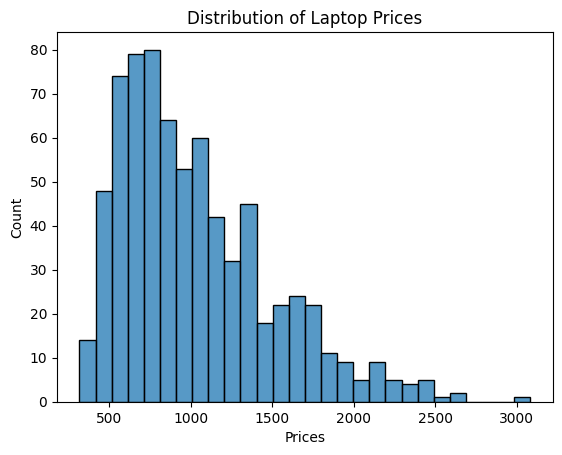

In [ ]:
# # Visualizting the distribution of prices

sns.histplot(data=df, x='Price_usd', binwidth=100)
plt.title('Distribution of Laptop Prices')
plt.xlabel('Prices')
plt.ylabel('Count');

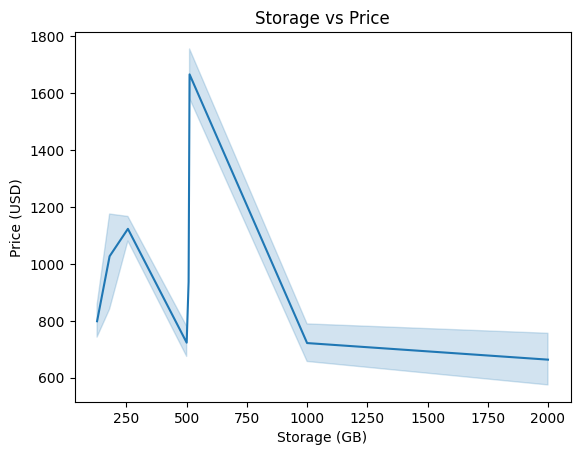

In [ ]:
# Visualizing the relationship between storage and price

sns.lineplot(data=df, x='Storage(GB)', y='Price_usd')
plt.title('Storage vs Price')
plt.xlabel('Storage (GB)')
plt.ylabel('Price (USD)');

Possible Number of Cores: 2 , 4


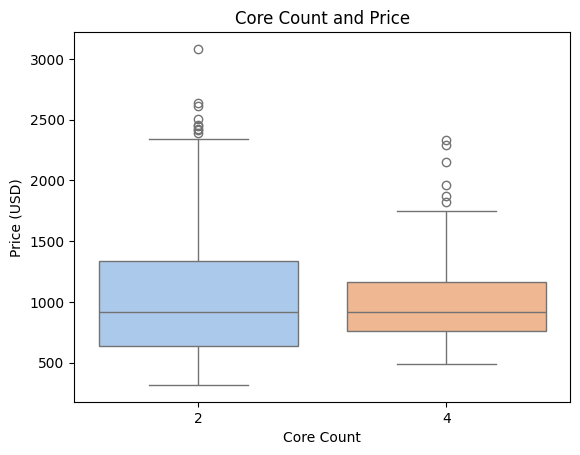

In [ ]:
# Visualizating the distribution of prices based on core count

print('Possible Number of Cores:',
      df['Cores'].value_counts().index[0],
      ',',
      df['Cores'].value_counts().index[1])

sns.boxplot(data=df, x='Cores', y='Price_usd', palette='pastel')
plt.title('Core Count and Price')
plt.xlabel('Core Count')
plt.ylabel('Price (USD)');

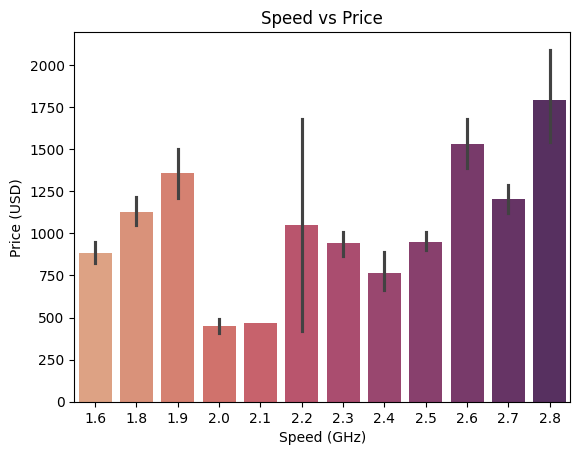

In [ ]:
# Relationship between speed and price

sns.barplot(data=df, x='Speed(GHz)', y='Price_usd', palette='flare')
plt.title('Speed vs Price')
plt.xlabel('Speed (GHz)')
plt.ylabel('Price (USD)');

Text(0, 0.5, 'Price (USD)')

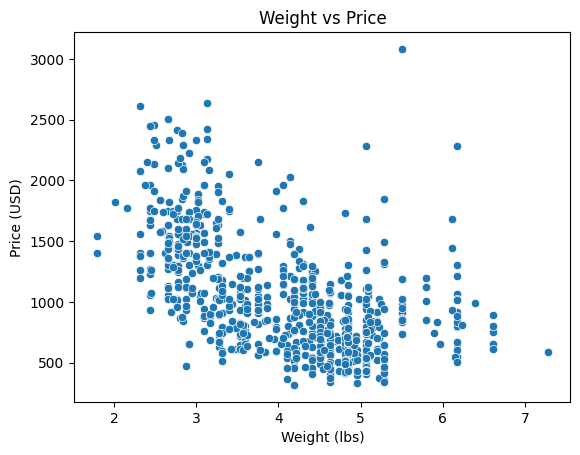

In [ ]:
# Relationship between weight and price

sns.scatterplot(data=df, x='Weight(lbs)', y='Price_usd', palette='Set2')
plt.title('Weight vs Price')
plt.xlabel('Weight (lbs)')
plt.ylabel('Price (USD)')

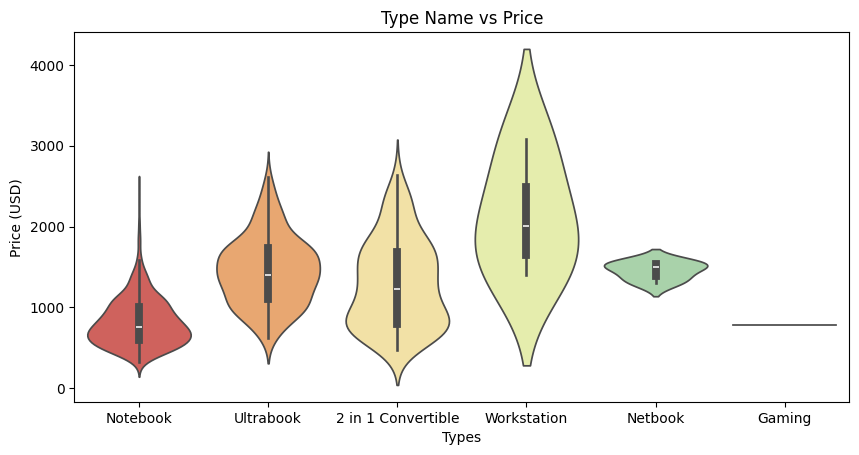

In [ ]:
# Visualizing the relationship between typename and price

plt.figure().set_figwidth(10)
sns.violinplot(data=df, x='TypeName', y='Price_usd', palette='Spectral')
plt.title('Type Name vs Price')
plt.xlabel('Types')
plt.ylabel('Price (USD)');

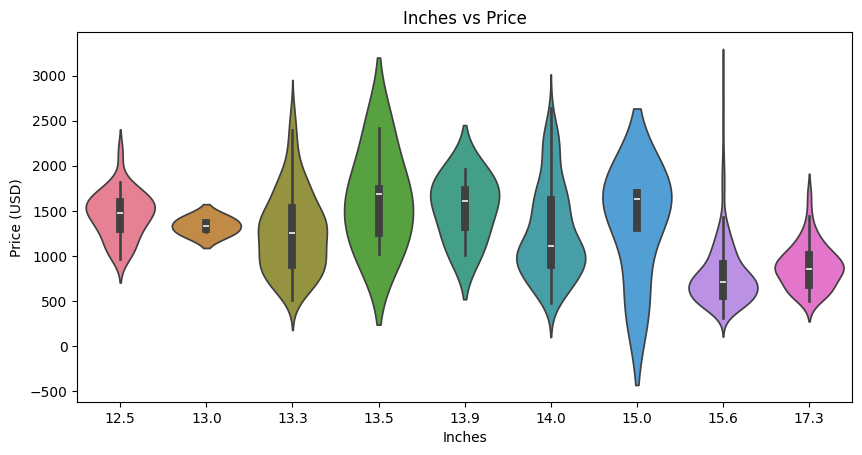

In [ ]:
# Visualizing the relationship between inches and price

plt.figure().set_figwidth(10)
sns.violinplot(data=df, x='Inches', y='Price_usd', palette='husl')
plt.title('Inches vs Price')
plt.xlabel('Inches')
plt.ylabel('Price (USD)');

## **Modeling**

<Figure size 1200x600 with 0 Axes>

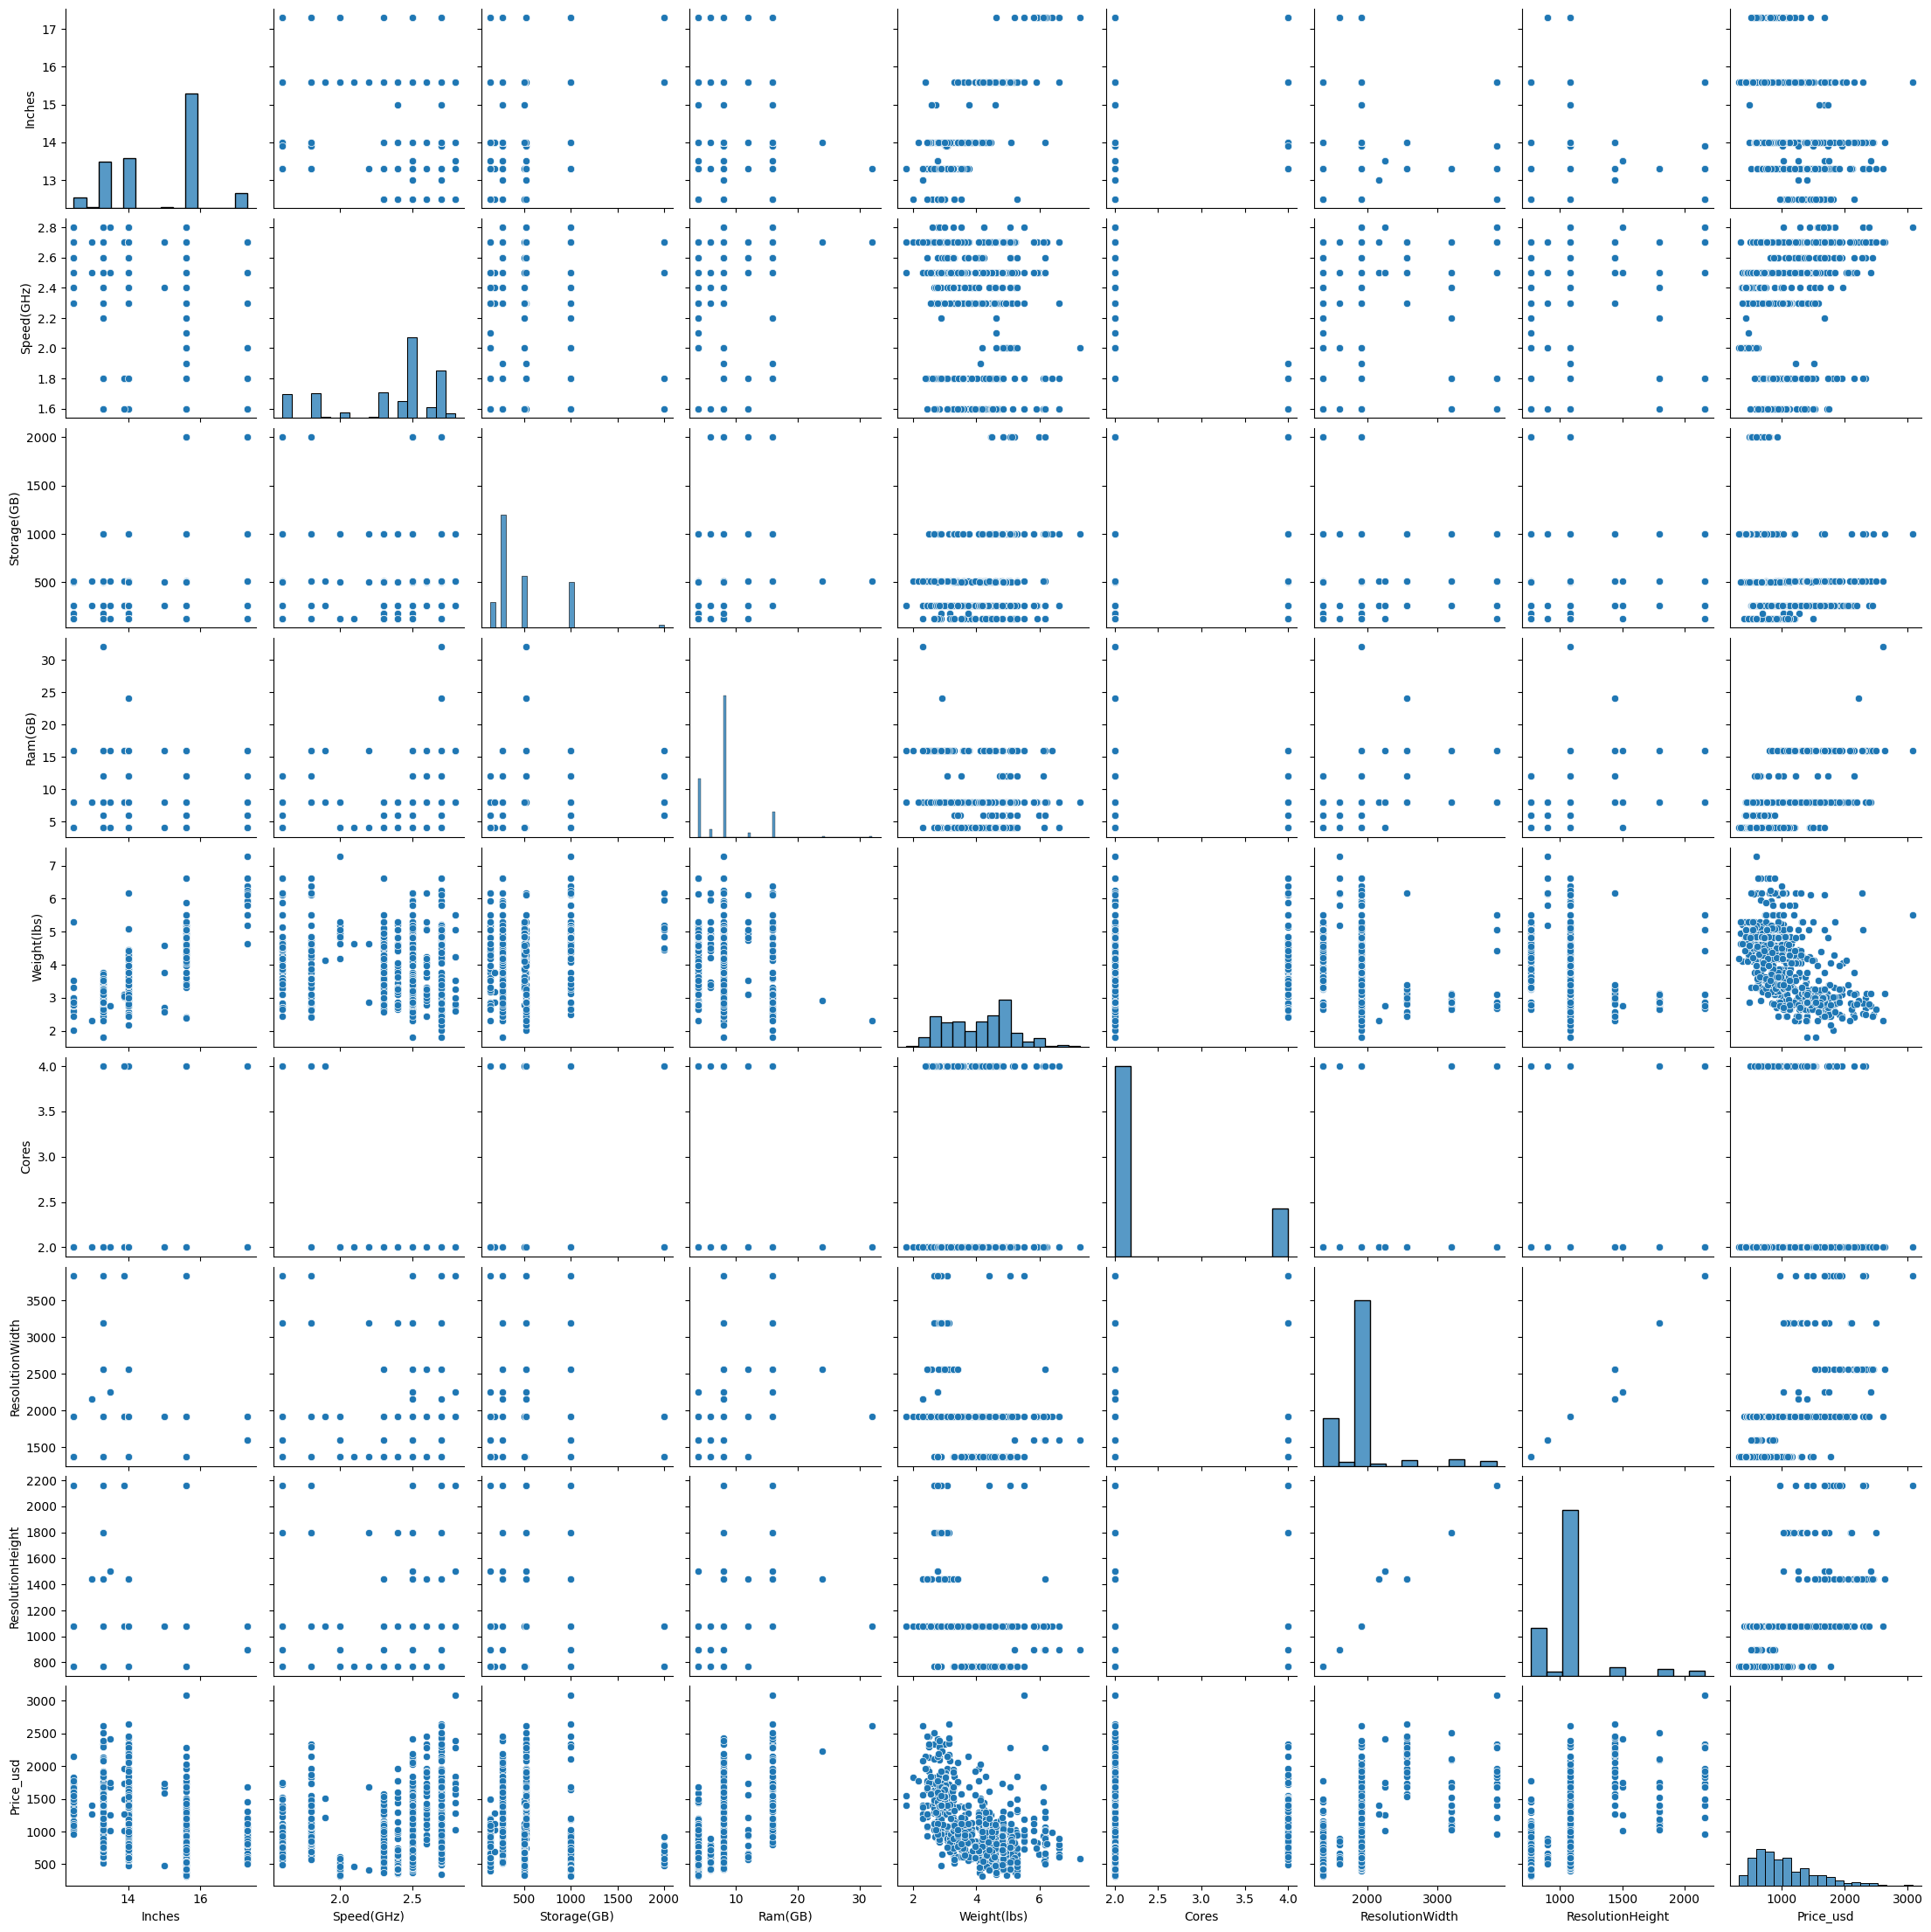

In [ ]:
# Plot scatter matrix for each pair of variables off diagonal and the histograms (or density plots) on the diagonal
plt.figure(figsize=(12, 6))
sns.pairplot(df[["Inches", "Speed(GHz)", "Storage(GB)", "Ram(GB)", "Weight(lbs)", "Cores", "ResolutionWidth", "ResolutionHeight", "Price_usd"]])
plt.show()

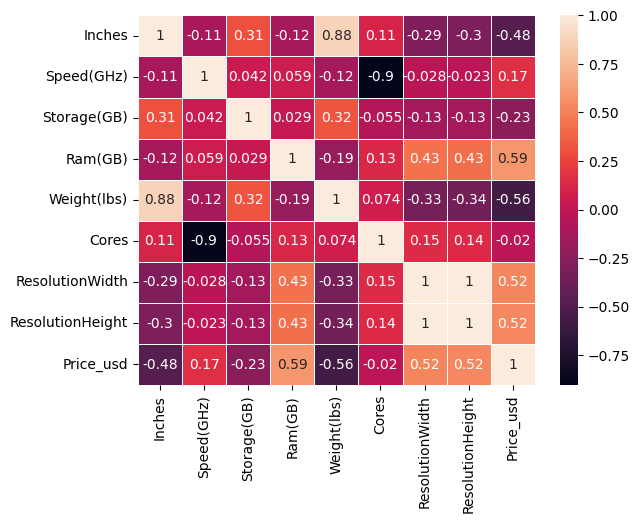

In [ ]:
# Plotting a heatmap

correlation_mat = df[["Inches", "Speed(GHz)", "Storage(GB)", "Ram(GB)", "Weight(lbs)", "Cores", "ResolutionWidth", "ResolutionHeight", "Price_usd"]].corr()
fig, ax = plt.subplots()
sns.heatmap(correlation_mat, annot=True, linewidth=0.5, ax=ax)
plt.show();

In [ ]:
# Out of Sample R-Squared (OSR2) Function

def OSR2(model, X_test, y_test, y_train):

    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)

    return (1 - SSE/SST)

In [ ]:
# One Hot Encoding

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
cat_data = df[["TypeName", "OpSys", "GPUBrand"]]
cont_data = df[["Inches", "Speed(GHz)", "Storage(GB)", "Ram(GB)", "Weight(lbs)", "Price_usd", "Cores", "ResolutionWidth",  "ResolutionHeight"]]
ohe_data = ohe.fit_transform(cat_data)
col_names = ohe.get_feature_names_out(["TypeName", "OpSys", "GPUBrand"])
ohe_df = pd.DataFrame(ohe_data, columns=col_names)
df_enc = pd.concat([cont_data, ohe_df], axis=1)
df_enc.head(5)

,Inches,Speed(GHz),Storage(GB),Ram(GB),Weight(lbs),Price_usd,Cores,ResolutionWidth,ResolutionHeight,TypeName_2 in 1 Convertible,...,TypeName_Ultrabook,TypeName_Workstation,OpSys_Linux,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,GPUBrand_AMD,GPUBrand_Intel,GPUBrand_Nvidia
2,15.6,2.5,256.0,8.0,4.10,537.38,2.0,1920.0,1080.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,14.0,1.8,512.0,16.0,2.87,1397.20,4.0,1920.0,1080.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,14.0,1.6,256.0,8.0,3.53,719.63,4.0,1920.0,1080.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10,15.6,2.5,500.0,4.0,4.10,368.13,2.0,1366.0,768.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
16,15.6,2.7,256.0,8.0,4.85,696.26,2.0,1920.0,1080.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_enc.dropna(how='any', axis=0, inplace=True)
df_enc.head(5)

,Inches,Speed(GHz),Storage(GB),Ram(GB),Weight(lbs),Price_usd,Cores,ResolutionWidth,ResolutionHeight,TypeName_2 in 1 Convertible,...,TypeName_Ultrabook,TypeName_Workstation,OpSys_Linux,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,GPUBrand_AMD,GPUBrand_Intel,GPUBrand_Nvidia
2,15.6,2.5,256.0,8.0,4.10,537.38,2.0,1920.0,1080.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,14.0,1.8,512.0,16.0,2.87,1397.20,4.0,1920.0,1080.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,14.0,1.6,256.0,8.0,3.53,719.63,4.0,1920.0,1080.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10,15.6,2.5,500.0,4.0,4.10,368.13,2.0,1366.0,768.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
16,15.6,2.7,256.0,8.0,4.85,696.26,2.0,1920.0,1080.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Linear Regression (sklearn)

from sklearn.model_selection import train_test_split

X = df_enc.drop("Price_usd", axis=1)
y = df_enc["Price_usd"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

print('Training Set Dimensions:', train.shape)
print('Test Set Dimensions:', test.shape)

Training Set Dimensions: (277, 23)
Test Set Dimensions: (119, 23)


In [ ]:
# Training set

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 427 to 512
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Inches                       277 non-null    float64
 1   Speed(GHz)                   277 non-null    float64
 2   Storage(GB)                  277 non-null    float64
 3   Ram(GB)                      277 non-null    float64
 4   Weight(lbs)                  277 non-null    float64
 5   Cores                        277 non-null    float64
 6   ResolutionWidth              277 non-null    float64
 7   ResolutionHeight             277 non-null    float64
 8   TypeName_2 in 1 Convertible  277 non-null    float64
 9   TypeName_Gaming              277 non-null    float64
 10  TypeName_Netbook             277 non-null    float64
 11  TypeName_Notebook            277 non-null    float64
 12  TypeName_Ultrabook           277 non-null    float64
 13  TypeName_Workstation   

In [ ]:
# Trying a base linear regression model

from sklearn.linear_model import LinearRegression

base_model = LinearRegression().fit(X_train, y_train)

OSR2(base_model, X_test, y_test, y_train)

0.6860051549748973

In [ ]:
# Model 0
import statsmodels.formula.api as smf
model0 = smf.ols(formula='Price_usd ~ Inches + Q("Speed(GHz)")+ Q("Storage(GB)") + Q("Ram(GB)")+ Q("Weight(lbs)") + Cores + ResolutionHeight + ResolutionWidth',
                 data=train).fit()

print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_usd   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     82.77
Date:                Wed, 08 May 2024   Prob (F-statistic):           5.87e-68
Time:                        10:53:13   Log-Likelihood:                -1914.2
No. Observations:                 277   AIC:                             3846.
Df Residuals:                     268   BIC:                             3879.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1217.7009    466.819  

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF function
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

In [ ]:
# VIF for Model 0

features = ["Inches", "Speed(GHz)", "Storage(GB)", "Ram(GB)", "Weight(lbs)", "Cores", "ResolutionWidth", 'ResolutionHeight']
VIF(train, features)

Inches               5.550786
Speed(GHz)          12.826080
Storage(GB)          1.095711
Ram(GB)              1.289466
Weight(lbs)          5.847802
Cores               13.336868
ResolutionWidth     82.404383
ResolutionHeight    82.914291
dtype: float64

In [ ]:
# Model 1
import statsmodels.formula.api as smf

model1 = smf.ols(formula='Price_usd ~ Inches + Q("Speed(GHz)")+ Q("Storage(GB)") + Q("Ram(GB)")+ Q("Weight(lbs)") + Cores + ResolutionWidth',
                 data=train).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_usd   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     90.72
Date:                Wed, 08 May 2024   Prob (F-statistic):           4.26e-67
Time:                        11:06:33   Log-Likelihood:                -1918.7
No. Observations:                 277   AIC:                             3853.
Df Residuals:                     269   BIC:                             3882.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1249.8411    473.382  

In [ ]:
# VIF for Model 1 | Dropped ResolutionHeight

features = ["Inches", "Speed(GHz)", "Storage(GB)", "Ram(GB)", "Weight(lbs)", "Cores", "ResolutionWidth"]
VIF(X_train, features)

Inches              5.545768
Speed(GHz)         12.810946
Storage(GB)         1.095618
Ram(GB)             1.289411
Weight(lbs)         5.797935
Cores              13.336639
ResolutionWidth     1.291202
dtype: float64

In [ ]:
# Model 2

model2 = smf.ols(formula='Price_usd ~ Inches + Q("Speed(GHz)")+ Q("Storage(GB)")+ Q("Ram(GB)")+ Q("Weight(lbs)") + ResolutionWidth',
                 data=train).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_usd   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     102.5
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.16e-66
Time:                        11:07:06   Log-Likelihood:                -1922.2
No. Observations:                 277   AIC:                             3858.
Df Residuals:                     270   BIC:                             3884.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -339.3064    325.046  

In [ ]:
# VIF for Model 2 | Dropped Cores

features = ["Inches", "Speed(GHz)", "Storage(GB)", "Ram(GB)", "Weight(lbs)", "ResolutionWidth"]
VIF(X_train, features)

Inches             5.397693
Speed(GHz)         1.047494
Storage(GB)        1.095192
Ram(GB)            1.145958
Weight(lbs)        5.713425
ResolutionWidth    1.237176
dtype: float64

In [ ]:
# Model 3

model3 = smf.ols(formula='Price_usd ~ Q("Speed(GHz)")+ Q("Storage(GB)") + Q("Ram(GB)") + ResolutionWidth',
                 data=train).fit()

print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_usd   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     101.1
Date:                Wed, 08 May 2024   Prob (F-statistic):           1.33e-52
Time:                        11:08:02   Log-Likelihood:                -1960.4
No. Observations:                 277   AIC:                             3931.
Df Residuals:                     272   BIC:                             3949.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -558.5667    133.610  

In [ ]:
# Model 4
model4 = smf.ols(formula='Price_usd ~ Q("Speed(GHz)") + Q("Ram(GB)")+ Q("Weight(lbs)") + Cores + ResolutionWidth',
                 data=train).fit()

print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_usd   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     123.9
Date:                Wed, 08 May 2024   Prob (F-statistic):           6.91e-68
Time:                        11:08:06   Log-Likelihood:                -1921.8
No. Observations:                 277   AIC:                             3856.
Df Residuals:                     271   BIC:                             3877.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -789.4554    421.684  

In [ ]:
# Calculating scores for Models 1, 2, 3, 4

from sklearn.metrics import r2_score

# Models and their parameter lists
model_names = [model0, model1, model2, model3, model4]
parameter_list = [model0.params.index.tolist(),
                  model1.params.index.tolist(),
                  model2.params.index.tolist(),
                  model3.params.index.tolist(),
                  model4.params.index.tolist()]

# Storing out of sample R-squared (OSR2) values for each model
osr2_results = []

# Calculating the OSR2 for each model
for model in model_names:
  osr2 = OSR2(model, X_test, y_test, y_train)
  osr2_results.append(osr2)

# Creating a dataframe to store the results
results_df = pd.DataFrame({'Model Name': ['model0', 'model1', 'model2', 'model3', 'model4'],
                           'Parameter List': [', '.join(parameters) for parameters in parameter_list],
                           'OSR2': osr2_results})
results_df

,Model Name,Parameter List,OSR2
0,model0,"Intercept, Inches, Q(""Speed(GHz)""), Q(""Storage...",0.671126
1,model1,"Intercept, Inches, Q(""Speed(GHz)""), Q(""Storage...",0.690713
2,model2,"Intercept, Inches, Q(""Speed(GHz)""), Q(""Storage...",0.679010
3,model3,"Intercept, Q(""Speed(GHz)""), Q(""Storage(GB)""), ...",0.606334
4,model4,"Intercept, Q(""Speed(GHz)""), Q(""Ram(GB)""), Q(""W...",0.675682


In [ ]:
# Fitting into a Decision Tree Regressor Model

from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(min_samples_leaf=5, ccp_alpha=0.01, random_state=88)
dtr = dtr.fit(X_train, y_train)

Node count = 89


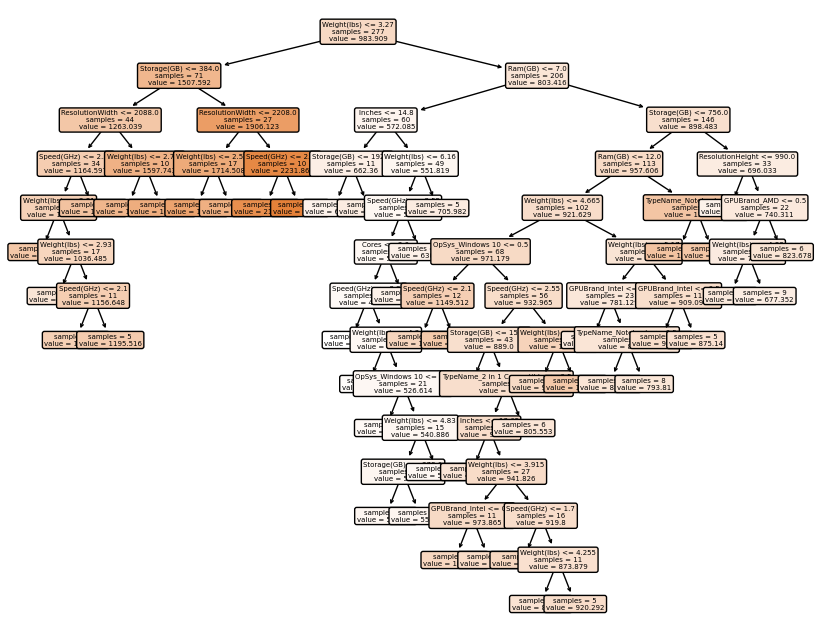

In [ ]:
# Plotting the tree

from sklearn.tree import plot_tree

print('Node count =', dtr.tree_.node_count)
plt.figure(figsize=(10,8))
plot_tree(dtr, feature_names=X_train.columns, class_names=True, filled=True, impurity=False, rounded=True, fontsize=5)
plt.show();

In [ ]:
# Calculating the OSR2 for the Decision Tree Regressor

OSR2(dtr, X_test, y_test, y_train)

0.64158826537989

In [ ]:
# Improving the model using PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

osr2 = []

for num in range(1,23):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=num)
    X_pca = pca.fit_transform(X_scaled)

    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=88)

    dtr = dtr.fit(X_train_pca, y_train)
    osr2.append(OSR2(dtr, X_test_pca, y_test_pca, y_train_pca))
    print(f"Number of Columns after PCA is {num}, OSR^2 is:",  OSR2(dtr, X_test_pca, y_test_pca, y_train_pca))

print(max(osr2))

Number of Columns after PCA is 1, OSR^2 is: 0.40291371050953595
Number of Columns after PCA is 2, OSR^2 is: 0.39209410627350494
Number of Columns after PCA is 3, OSR^2 is: 0.4295954039615255
Number of Columns after PCA is 4, OSR^2 is: 0.43143195178001115
Number of Columns after PCA is 5, OSR^2 is: 0.5416420876256102
Number of Columns after PCA is 6, OSR^2 is: 0.43261692126586326
Number of Columns after PCA is 7, OSR^2 is: 0.4386386265659815
Number of Columns after PCA is 8, OSR^2 is: 0.434001302139139
Number of Columns after PCA is 9, OSR^2 is: 0.4596025444977794
Number of Columns after PCA is 10, OSR^2 is: 0.48314003414327655
Number of Columns after PCA is 11, OSR^2 is: 0.49129912370581963
Number of Columns after PCA is 12, OSR^2 is: 0.458427296771475
Number of Columns after PCA is 13, OSR^2 is: 0.4184006842912761
Number of Columns after PCA is 14, OSR^2 is: 0.40230421429170804
Number of Columns after PCA is 15, OSR^2 is: 0.41181829715363905
Number of Columns after PCA is 16, OSR^2 is

In [ ]:
# Trying a Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
rf = RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators = 300, random_state=88, verbose=2)
rf.fit(X_train, y_train)

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84 of 300
building tree 85 of 300
building tree 86 of 300
building tree 87 of 300
building tree 88 of 300
building tree 89 of 300
building tree 90 of 300
building tree 91 of 300
building tree 92 of 300
building tree 93 of 300
building tree 94 of 300
building tree 95 of 300
building tree 96 of 300
building tree 97 of 300
building tree 98 of 300
building tree 99 of 300
building tree 100 of 300
building tree 101 of 300
building tree 102 of 300
building tree 103 of 300
building tree 104 of 300
building tree 105 of 300
building tree 106 of 300
building tree 107 of 300
building tree 108 of 300
building tree 109 of 300
buildi

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s


building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300
building tree 203 of 300
building tree 204 of 300
building tree 205 of 300
building tree 206 of 300
building tree 207 of 300
building tree 208 of 300
building tree 209 of 300
building tree 210 of 300
building tree 211 of 300
building tree 212 of 300
building tree 213 of 300
building tree 214 of 300
building tree 215 of 300
building tree 216 of 300
building tree 217 of 300
building tree 218 of 300
building tree 219 of 300
building tree 220 of 300
building tree 221 of 300
building tree 222 of 300
building tree 223 of 300
building tree 224 of 300
building tree 225 of 300
building tree 226 of 300
building tree 227 of 300
building tree 228 of 300


RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators=300,
                      random_state=88, verbose=2)

In [ ]:
# OSR2 for Random Forest Regressor

print(OSR2(rf, X_test, y_test, y_train))

0.7224139430287919


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [ ]:
# Applying Gradient Boosting

from sklearn.ensemble import GradientBoostingRegressor

for i in range(1000, 5000, 1000):
    gbr = GradientBoostingRegressor(n_estimators=i, learning_rate= 0.001, max_leaf_nodes=3, max_depth=15, min_samples_leaf=10, random_state=88, verbose=1)
    gbr.fit(X_train, y_train)

    print(f"The number of boosting stages is {i}. OSR2:", OSR2(gbr, X_test, y_test, y_train))

      Iter       Train Loss   Remaining Time 
         1      204114.5213            1.54s
         2      203876.1138            1.97s
         3      203638.1828            3.26s
         4      203400.7274            3.00s
         5      203163.7467            3.14s
         6      202927.2397            2.98s
         7      202691.2055            2.91s
         8      202455.6431            2.89s
         9      202220.5516            2.84s
        10      201985.9301            2.82s
        20      199665.3561            2.11s
        30      197390.7553            1.79s
        40      195161.2169            1.59s
        50      192975.8483            1.45s
        60      190833.7742            1.37s
        70      188734.1371            1.32s
        80      186676.0962            1.29s
        90      184658.8274            1.25s
       100      182681.5229            1.23s
       200      164939.8609            1.00s
       300      150281.4111            0.83s
       40

**The best OSR2 we recieved is .74 through 4000 boosting stages.**